<a href="https://colab.research.google.com/github/vik235/CodeMixed-Hinglish/blob/master/CodeMixedHinglish_Dev_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!git  clone https://github.com/vik235/CodeMixed-Hinglish 

Cloning into 'CodeMixed-Hinglish'...
remote: Enumerating objects: 231, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 804 (delta 84), reused 195 (delta 52), pack-reused 573
Receiving objects: 100% (804/804), 71.84 MiB | 11.90 MiB/s, done.
Resolving deltas: 100% (260/260), done.
Checking out files: 100% (696/696), done.


In [6]:
%cd CodeMixed-Hinglish/
!dir

/content/CodeMixed-Hinglish
Colab	    FinalModels  modelperf  NoteBooks	      training.py
data	    hot.py	 model.py   Preprocessing.py  Transliteration
dataset.py  logs	 models     README.md


In [7]:
!pip install keras_metrics
!pip install tensorboardcolab

In [8]:
!ls

Colab	    FinalModels  modelperf  NoteBooks	      training.py
data	    hot.py	 model.py   Preprocessing.py  Transliteration
dataset.py  logs	 models     README.md


In [9]:
import os
import keras
import io
import csv
import time
import datetime
import itertools

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences 
import numpy as np
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers import Dropout, SimpleRNN, LSTM, Bidirectional, GRU
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import keras_metrics
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
import keras.backend as K

## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import time

from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback


Using TensorFlow backend.


In [10]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-12-09 02:06:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-12-09 02:06:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-12-09 02:06:01--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [11]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [24]:
!ls


Colab	     glove.6B.100d.txt	glove.6B.zip  model.py		README.md
data	     glove.6B.200d.txt	hot.py	      models		training.py
dataset.py   glove.6B.300d.txt	logs	      NoteBooks		Transliteration
FinalModels  glove.6B.50d.txt	modelperf     Preprocessing.py


In [0]:
##Set params for the model
tensorBoard_logs_dir = '.\\logs\\'
model_dir = '.\\models\\'
glove_dir = 'models\\glove'
train_dir = 'data/train/'
test_dir = 'data/test'
dev_dir = 'data/dev/'

train_x = 'newtrainMessages.csv'
train_y = 'newtrainLabels.csv'

dev_x = 'devmessages.csv'
dev_y = 'devlabels.csv'

dev2_x = 'aug1Devmessages.csv'
dev2_y = 'aug1DevLabels.csv'

maxlen = 200
max_words = 10000
num_filters = 64 
embedding_dim = 100
num_filters = 64 
num_classes = 3



In [26]:
traintexts = []
trainlabels = []

devtexts = []
devlabels = []

dev2texts = []
dev2labels = []


with open(os.path.join(train_dir, train_x), newline ='') as messageData:
    reader = csv.reader(messageData)
    for row in reader:
        message = (''.join(row))
        traintexts.append(message)

with open(os.path.join(train_dir, train_y)) as labelData:
    reader = csv.reader(labelData)
    for row in reader:
        #label = (''.join(row))
        trainlabels.append(row)

with open(os.path.join(dev_dir, dev_x), newline ='') as messageData:
    reader = csv.reader(messageData)
    for row in reader:
        message = (''.join(row))
        devtexts.append(message)

with open(os.path.join(dev_dir, dev_y)) as labelData:
    reader = csv.reader(labelData)
    for row in reader:
        #label = (''.join(row))
        devlabels.append(row)

with open(os.path.join(dev_dir, dev2_x), newline ='') as messageData:
    reader = csv.reader(messageData)
    for row in reader:
        message = (''.join(row))
        dev2texts.append(message)

with open(os.path.join(dev_dir, dev2_y)) as labelData:
    reader = csv.reader(labelData)
    for row in reader:
        #label = (''.join(row))
        dev2labels.append(row)


trainlabels = np.squeeze(trainlabels)
devlabels = np.squeeze(devlabels)
dev2labels = np.squeeze(dev2labels)
#testlabels = np.squeeze(testlabels)

cp_devlabels = devlabels
cp_dev2labels = dev2labels
#cp_testlabels = testlabels

trainlabels = np_utils.to_categorical(trainlabels, num_classes=num_classes)
devlabels = np_utils.to_categorical(devlabels, num_classes=num_classes)
dev2labels = np_utils.to_categorical(dev2labels, num_classes=num_classes)
#testlabels = np_utils.to_categorical(testlabels, num_classes=num_classes)


print('Train labels:', np.sum(trainlabels, axis = 0), int(np.sum(trainlabels)))
print('Dev labels:', np.sum(devlabels, axis = 0), int(np.sum(devlabels)))
print('Dev2 labels:', np.sum(dev2labels, axis = 0), int(np.sum(dev2labels)))
#print('Test labels:', np.sum(testlabels, axis = 0), int(np.sum(testlabels)))

print('Train text size:', len(traintexts))
print('Dev text size:', len(devtexts))
print('Dev2 text size:', len(dev2texts))
#print('Test text size:', len(testtexts))


Train labels: [3572. 1638. 2724.] 7934
Dev labels: [228.  69. 403.] 700
Dev2 labels: [229. 275. 403.] 907
Train text size: 7934
Dev text size: 700
Dev2 text size: 907


In [27]:
print(cp_devlabels[0:10])
print(cp_dev2labels[0:10])

['0' '2' '0' '2' '0' '2' '2' '2' '0' '2']
['1' '1' '1' '1' '1' '1' '1' '1' '1' '1']


In [28]:
texts = []
for t in traintexts:
    texts.append(t)
for t in devtexts:
    texts.append(t)
for t in dev2texts:
    texts.append(t)
    
devetexts = []
develabels = []

'''
cp_develabels = []

for t in devtexts:
    devetexts.append(t)

for t in devlabels:
    develabels.append(t)
#for t in testlabels:
#    develabels.append(t)

for t in cp_devlabels:
    cp_develabels.append(t)
#for t in cp_testlabels:
#    cp_develabels.append(t)

'''


'\ncp_develabels = []\n\nfor t in devtexts:\n    devetexts.append(t)\n\nfor t in devlabels:\n    develabels.append(t)\n#for t in testlabels:\n#    develabels.append(t)\n\nfor t in cp_devlabels:\n    cp_develabels.append(t)\n#for t in cp_testlabels:\n#    cp_develabels.append(t)\n\n'

In [29]:

##Tokenizer, Sequencer and padding via Keras
###DO NOT RUN THIS
np.random.seed(1) 

#tokenize the data for the maxwords
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

#Generate the sequences on texts on the the data by tokenizer
trainsequences = tokenizer.texts_to_sequences(traintexts)
devsequences = tokenizer.texts_to_sequences(devtexts)
dev2sequences = tokenizer.texts_to_sequences(dev2texts)
#testsequences = tokenizer.texts_to_sequences(testtexts)
#devesequences = tokenizer.texts_to_sequences(devetexts)

word_index = tokenizer.word_index
print('Found %s unique tokens.'% len(word_index))
#print(word_index)
#Padding sequences (making them all equal)
traindata = pad_sequences(trainsequences, maxlen=maxlen)
devdata = pad_sequences(devsequences, maxlen=maxlen)
dev2data = pad_sequences(dev2sequences, maxlen=maxlen)
#testdata = pad_sequences(testsequences, maxlen=maxlen)
#devedata = pad_sequences(devesequences, maxlen=maxlen)

print('Train labels before array:', trainlabels[0:10])
print('devlabels labels before array:', devlabels[0:10])
print('dev2labels labels before array:', dev2labels[0:10])

trainlabels = np.asarray(trainlabels)
devlabels = np.asarray(devlabels)
dev2labels = np.asarray(dev2labels)
#testlabels = np.asarray(testlabels)
#develabels = np.asarray(develabels)

print('Train labels after array:', trainlabels[0:10])
print('devlabels labels after array:', devlabels[0:10])
print('dev2labels labels after array:', dev2labels[0:10])

print('Shape of the train data tensor:' , traindata.shape)
print('Shape of the label tensor:' , trainlabels.shape)

print('Shape of the dev data tensor:' , devdata.shape)
print('Shape of the dev tensor:' , devlabels.shape)

print('Shape of the dev2 data tensor:' , dev2data.shape)
print('Shape of the dev2 tensor:' , dev2labels.shape)
'''
print('Shape of the test data tensor:' , testdata.shape)
print('Shape of the test tensor:' , testlabels.shape)

print('Shape of the Combined Dev tensor:' , devedata.shape)
print('Shape of the Combined Dev label tensor:' , develabels.shape)
'''


Found 8366 unique tokens.
Train labels before array: [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
devlabels labels before array: [[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]
dev2labels labels before array: [[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
Train labels after array: [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
devlabels labels after array: [[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]
dev2labels labels after array: [[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
Shape of the train data tensor: (7934, 200)
Shape of the label tensor: 

"\nprint('Shape of the test data tensor:' , testdata.shape)\nprint('Shape of the test tensor:' , testlabels.shape)\n\nprint('Shape of the Combined Dev tensor:' , devedata.shape)\nprint('Shape of the Combined Dev label tensor:' , develabels.shape)\n"

In [30]:
np.random.seed(1) 
embedding_index = {}
f = open(os.path.join('glove.6B.200d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
   # print(word)
    coefs = np.asarray(values[1:], dtype = 'float32')
    embedding_index[word] = coefs
f.close()
print('Found %s word vectors' % len(embedding_index))

Found 400000 word vectors


In [32]:
embedding_dim = 200
np.random.seed(1) 
embedding_matrix = np.zeros((max_words, embedding_dim))
count = 0 
ignored_words = []
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            ignored_words.append(word)  
            count = count + 1
print(embedding_matrix.shape)       


(10000, 200)


In [33]:
traindata[0:10]

array([[   0,    0,    0, ..., 1303,   83, 2978],
       [   0,    0,    0, ..., 4898,   83, 2978],
       [   0,    0,    0, ..., 1303,    6, 2978],
       ...,
       [   0,    0,    0, ...,    0,   16,   26],
       [   0,    0,    0, ...,  887, 2980,  102],
       [   0,    0,    0, ..., 2980,  887,  102]], dtype=int32)

In [0]:
def save_model(model_qualifier, model, location):
    model_name = model_qualifier + "-{}".format(datetime.date.today()) + "-{}".format(time.time())
    try:
        model.save(os.path.join(location, model_name))
        #plot_model(model, to_file=os.path.join(location, model_name)+ '.png')
    except:
        print("Exception occured while saving the model to disc.")

In [0]:
K.clear_session()
%reload_ext tensorboard

In [36]:
maxlen = 200              # Maximum length of the message/ tweet to be considered
max_words = 10000         # vocab length
num_filters = 64
num_classes = 3
num_hidden_lstm = 32
num_hidden_rnn_final = 32
num_dense_fc = 64
recurrent_dropout = 0.2
fc_dropout = 0.5
cnn_dropout = 0.5
kernel_size = 7

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
'''
model.add(LSTM(32, recurrent_dropout = 0.2, return_sequences=True))
model.add(LSTM(32, recurrent_dropout = 0.2, return_sequences=True))
model.add(LSTM(32, recurrent_dropout = 0.2, return_sequences=True))
model.add(LSTM(32))

model.add(Conv1D(num_filters, kernel_size, activation='relu', padding='same'))
model.add(Dropout(cnn_dropout))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, kernel_size, activation='relu', padding='same'))
model.add(Dropout(cnn_dropout))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, kernel_size, activation='relu', padding='same'))
model.add(Dropout(cnn_dropout))
model.add(GlobalMaxPooling1D())
'''
model.add(GRU(num_hidden_lstm, recurrent_dropout=recurrent_dropout, return_sequences=True))
model.add(GRU(num_hidden_lstm, recurrent_dropout=recurrent_dropout, return_sequences=True))
model.add(GRU(num_hidden_lstm, recurrent_dropout=recurrent_dropout, return_sequences=True))
model.add(GRU(num_hidden_rnn_final, recurrent_dropout=recurrent_dropout))
#model.add(Dense(num_dense_fc, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(fc_dropout))
#model.add(Dense(num_dense_fc, activation='relu'))
#model.add(Dropout(fc_dropout))
#model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True
model_name = "CodeMixed-Final-EmbFalse-LSTM_32x1_DO-Dense_64x1-Dense_3_Softmax-Model"
model.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          2000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 200, 32)           22368     
_________________________________________________________________
gru_2 (GRU)                  (None, 200, 32)           6240      
_________________________________________________________________
gru_3 (GRU)                  (None, 200, 32)           6240      
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99      

In [37]:
optimizer = Adam(lr=0.01, decay=1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])

In [38]:
#callbacks 
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, restore_best_weights= True)

modelcheckpoint = ModelCheckpoint('models/Best_'+ model_name+ '.h5', monitor='val_loss', mode='min', verbose=1)

reduce_lr_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
tensorboard = TensorBoard(log_dir = tensorBoard_logs_dir + '{}'.format(model_name), 
                         histogram_freq=1,
                         #embeddings_freq=1
                         )
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://eac0160b.ngrok.io


In [39]:
history = model.fit(traindata, trainlabels, epochs = 50, batch_size = 128,validation_split=0.2, callbacks = [tensorboard, earlystopping, reduce_lr_plateau, modelcheckpoint, TensorBoardColabCallback(tbc)])
#results = model.evaluate(testdata, testlabels)
#print("Evaluation results: ", results)
#model.save_weights(model_dir + '{}'.format(model_name)+'.h5')
save_model(model_name, model, "models")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6347 samples, validate on 1587 samples



Epoch 1/50
6347/6347 [==============================] - 86s 14ms/step - loss: 0.4322 - categorical_accuracy: 0.8335 - val_loss: 0.7599 - val_categorical_accuracy: 0.7461


Epoch 00001: saving model to models/Best_CodeMixed-Final-EmbFalse-LSTM_32x1_DO-Dense_64x1-Dense_3_Softmax-Model.h5
Epoch 2/50
6347/6347 [==============================] - 83s 13ms/step - loss: 0.0389 - categorical_accuracy: 0.9883 - val_loss: 1.2101 - val_categorical_accuracy: 0.6982

Epoch 00002: saving model to models/Best_CodeMixed-Final-EmbFalse-LSTM_32x1_DO-Dense_64x1-Dense_3_Softmax-Model.h5
Epoch 3/50
6347/6347 [==============================] - 83s 13ms/step - loss: 0.0136 - categorical_accuracy: 0.9959 - val_loss: 1.0295 - val_categorical_accuracy: 0.7782

Epoch 00003: saving model to models/Best_CodeMixed-Final-EmbFalse-LSTM_32x1_DO-Dense_64x1-Dense_3_Softmax-Mod

In [40]:


\beginhistory.history.items()
models/Best_CodeMixed-Final-Emb-BiLSTM_32x2_DO-Dense_64x2-Dense_3_Softmax-Model.h5

SyntaxError: ignored

In [41]:
print('Loading model: ', 'models/Best_'+ model_name+ '.h5')
Bestmodel = load_model('models/Best_'+ model_name+ '.h5')
y_pred = Bestmodel.predict_classes(devdata, batch_size=64, verbose=1)
print((y_pred[0:30]))
dev_labels = [int(label) for label in cp_devlabels]
print(np.asarray(dev_labels[0:30]))
print(classification_report(dev_labels, y_pred))

Loading model:  models/Best_CodeMixed-Final-EmbFalse-LSTM_32x1_DO-Dense_64x1-Dense_3_Softmax-Model.h5
700/700 [==============================] - 7s 11ms/step
[0 2 0 2 1 2 1 2 0 2 0 2 1 0 2 0 2 0 0 2 0 2 2 2 1 2 1 2 2 0]
[0 2 0 2 0 2 2 2 0 2 0 2 0 0 2 2 2 0 0 2 0 2 2 2 0 2 1 2 1 0]
              precision    recall  f1-score   support

           0       0.67      0.82      0.74       228
           1       0.58      0.45      0.51        69
           2       0.88      0.80      0.84       403

    accuracy                           0.77       700
   macro avg       0.71      0.69      0.70       700
weighted avg       0.78      0.77      0.77       700



In [0]:
y_pred = Bestmodel.predict_classes(dev2data, batch_size=64, verbose=1)
print((y_pred[0:30]))
dev2_labels = [int(label) for label in cp_dev2labels]
print(np.asarray(dev2_labels[0:60]))
print(classification_report(dev2_labels, y_pred))

907/907 [==============================] - 1s 1ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
              precision    recall  f1-score   support

           0       0.53      0.70      0.60       229
           1       0.79      0.54      0.64       275
           2       0.74      0.77      0.76       403

    accuracy                           0.68       907
   macro avg       0.69      0.67      0.67       907
weighted avg       0.70      0.68      0.68       907



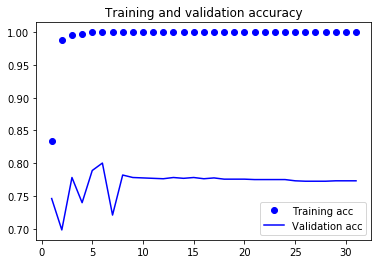

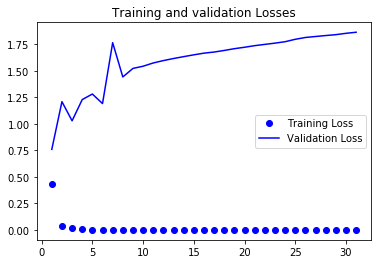

<Figure size 432x288 with 0 Axes>

In [42]:
#print("Evaluation results: ", results)
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label ='Training acc')
plt.plot(epochs, val_acc, 'b', label ='Validation acc')
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label ='Training Loss')
plt.plot(epochs, val_loss, 'b', label ='Validation Loss')
plt.title("Training and validation Losses")
plt.legend()
plt.figure()

plt.show()

In [0]:
%tensorboard --logdir tensorBoard_logs_dir

In [0]:
cnf_matrix = confusion_matrix(dev_labels, y_pred)

In [0]:
cnf_matrix

array([[257,   4,   1],
       [  0,  74,   1],
       [  0,   1, 451]])

In [44]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1','2'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=['0','1','2'], normalize=True,                      title='Normalized confusion matrix')

plt.show()

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [1]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1','2'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

NameError: ignored

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')